In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import pyopencl as cl
import time
import nibabel
import MappingFilter

In [2]:
MappingFilter.InitOpenCL('M1')

Apple M1 Max
Selecting device:  Apple M1 Max


In [13]:
a=nibabel.load('/Volumes/GoogleDrive/My Drive/Papers/FUN 2022/Data/LM1_700kHz_9PPW_BabelViscoInput.nii.gz').get_fdata()
b=nibabel.load('/Volumes/GoogleDrive/My Drive/Papers/FUN 2022/Data/LM1_700kHz_9PPW_CT.nii.gz').get_fdata().astype(np.float32)
a=np.ascontiguousarray(a)
b=np.ascontiguousarray(b)


In [14]:
SelBone=((a==2) | (a ==3))
print(SelBone.shape,b.shape)
UniqueHU=np.unique(b[SelBone])
print(UniqueHU.shape,len(UniqueHU))

(910, 875, 846) (910, 875, 846)
(930,) 930


In [15]:
CTMap=MappingFilter.MapFilter(b,SelBone.astype(np.uint8),UniqueHU)

0.0

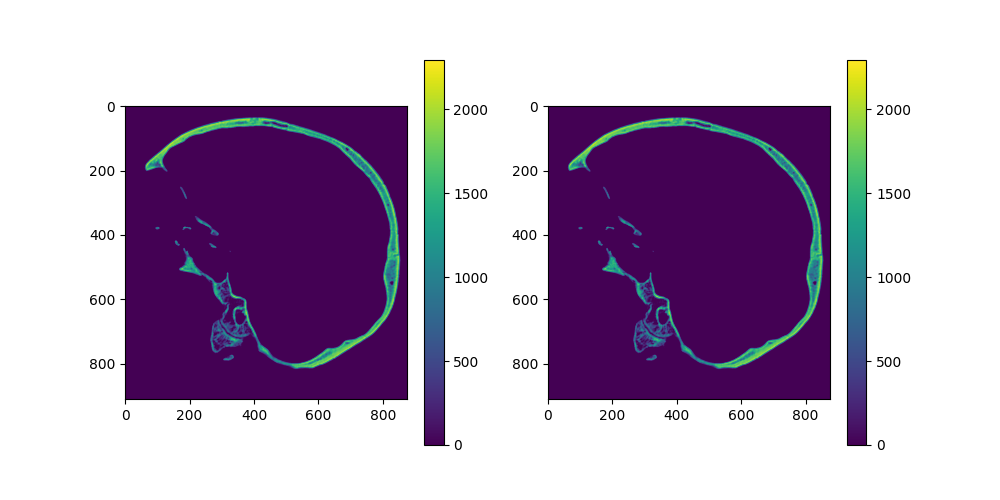

In [17]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(UniqueHU[CTMap[:,:,420]])
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(b[:,:,420])
plt.colorbar()
np.max(np.abs(UniqueHU[CTMap]-b))

In [22]:
np.std(np.diff(UniqueHU))

3.316463